In [1]:
# Neural Network
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError
import statsmodels.api as sm
import tensorflow as tf
import matplotlib.pyplot as plt
#from silence_tensorflow import silence_tensorflow
#silence_tensorflow()

In [2]:
# Check GPU Usage
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.1


The Data has 272 timesteps (Months):
- Training: 70% (190 months, ~15.8 years, May 2002–Feb 2018)
- Validation: 15% (41 months, ~3.4 years, Mar 2018–Jul 2021)
- Test: 15% (41 months, ~3.4 years, Aug 2021–Dec 2024)

Approximatelly 16 years of training data (capturing multiple seasonal cycles) while leaving enough for validation and testing.
Monthly data with yearly seasonality can capture full cycles (12 months each) in each split.

In [3]:
# Load the Data
data = pd.read_csv('C:\\Users\\cb7en\\OneDrive\\Documentos\\Stats Master - Wei\\Energy Data\\Ontario Hourly Consumption\\merged_Demand.csv', index_col='Date', parse_dates=True)

# check end of the data
data.sort_index(inplace=True)

data.index = pd.to_datetime(data.index)

monthly_tot = data['Ontario Demand'].resample('M').sum()

In [4]:
# Lookback Window: 12 months (1 year) to capture seasonality, predicting the 13th month. With 272 months, this gives 259 sequences (272 - 12).
data = pd.Series(monthly_tot,
                 index=pd.date_range(start='2002-05-31', periods=272, freq='M'))

# Split data chronologically
train_size = 190
val_size = 41
test_size = 41

train_data = data[:train_size].values.reshape(-1, 1) # first 190 months
val_data = data[train_size:train_size + val_size].values.reshape(-1, 1) # after 190, next 41 months
test_data = data[train_size + val_size:].values.reshape(-1, 1) # after (190+41) the next following 41 months

# Robust scaling
scaler = RobustScaler()
train_scaled = scaler.fit_transform(train_data) # only the training data
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

# Create sequences
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 24  # 1 year of past data (first with 12 and then later with 24)
X_train, y_train = create_sequences(train_scaled, lookback)
X_val, y_val = create_sequences(val_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

print(X_train.shape)  # Should be (178, 12, 1): 190 - 12 = 178 sequences
print(X_val.shape)   # Should be (29, 12, 1): 41 - 12 = 29 sequences
print(X_test.shape) # Should be (29, 12, 1): 41 - 12 = 29 sequences

(166, 24, 1)
(17, 24, 1)
(17, 24, 1)


In [5]:
# Simple GRU
model = Sequential()
model.add(GRU(units=32, input_shape=(lookback, 1), return_sequences=False))
model.add(Dense(units=1))  # Predict next month's demand

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3360      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
11/11 [==============================] - 5s 52ms/step - loss: 0.4163 - val_loss: 0.7581
Epoch 2/50
11/11 [==============================] - 0s 13ms/step - loss: 0.3774 - val_loss: 0.6461
Epoch 3/50
11/11 [==============================] - 0s 14ms/step - loss: 0.3538 - val_loss: 0.5954
Epoch 4/50
11/11 [==============================] - 0s 14ms/step - loss: 0.3433 - val_loss: 0.5585
Epoch 5/50
11/11 [==============================] - 0s 14ms/step - loss: 0.3340 - val_loss: 0.5391
Epoch 6/50
11/11 [==============================] - 0s 11ms/step - loss: 0.3229 - val_loss: 0.5112
Epoch 7/50
11/11 [==============================] - 0s 12ms/step - loss: 0.3131 - val_loss: 0.4803
Epoch 8/50
11/11 [==============================] - 0s 9ms/step - loss: 0.2998 - val_loss: 0.4486
Epoch 9/50
11/11 [==============================] - 0s 10ms/step - loss: 0.2866 - val_loss: 0.4230
Epoch 10/50
11/11 [==============================] - 0s 10ms/step - loss: 0.2742 - val_loss: 0.3820
Epoch 11/5

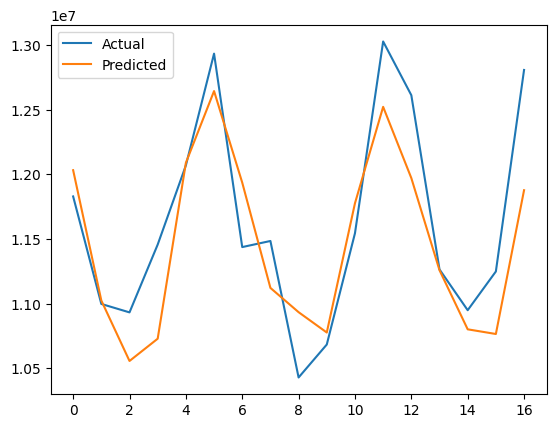

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    validation_data=(X_val, y_val), callbacks=[early_stopping])

# Predict and inverse transform
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_orig, y_pred)
print(f'Test MAE: {mae:,.2f}')

# Plot results
plt.plot(y_test_orig, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

Epoch 1/50
11/11 [==============================] - 2s 53ms/step - loss: 0.4023 - val_loss: 0.6741
Epoch 2/50
11/11 [==============================] - 0s 11ms/step - loss: 0.3448 - val_loss: 0.5484
Epoch 3/50
11/11 [==============================] - 0s 11ms/step - loss: 0.3337 - val_loss: 0.4924
Epoch 4/50
11/11 [==============================] - 0s 9ms/step - loss: 0.3322 - val_loss: 0.4952
Epoch 5/50
11/11 [==============================] - 0s 8ms/step - loss: 0.3307 - val_loss: 0.5070
Epoch 6/50
11/11 [==============================] - 0s 9ms/step - loss: 0.3269 - val_loss: 0.4971
Epoch 7/50
11/11 [==============================] - 0s 10ms/step - loss: 0.3231 - val_loss: 0.4928
Epoch 8/50
11/11 [==============================] - 0s 10ms/step - loss: 0.3206 - val_loss: 0.4968
Epoch 9/50
11/11 [==============================] - 0s 9ms/step - loss: 0.3203 - val_loss: 0.4935
Epoch 10/50
11/11 [==============================] - 0s 8ms/step - loss: 0.3210 - val_loss: 0.4828
Epoch 11/50
11

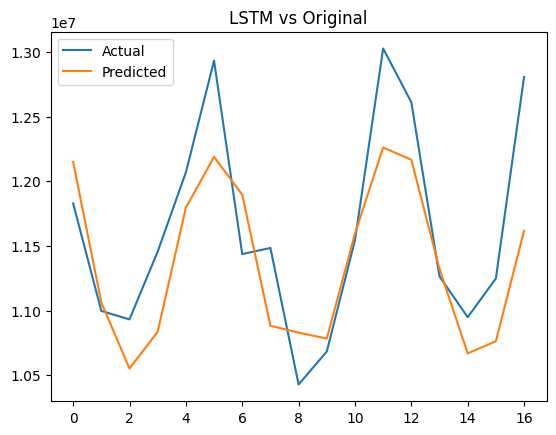

In [7]:
# Simple LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=32, input_shape=(lookback, 1), return_sequences=False))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=16,
                              validation_data=(X_val, y_val), callbacks=[early_stopping])

y_pred_lstm_scaled = model_lstm.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm_scaled)
mae_lstm = mean_absolute_error(y_test_orig, y_pred_lstm)
print(f"LSTM Test MAE: {mae_lstm:,.2f}")

# Plot results
plt.plot(y_test_orig, label='Actual')
plt.plot(y_pred_lstm, label='Predicted')
plt.title('LSTM vs Original')
plt.legend()
plt.show()

In [8]:
# Comparison
print(f'GRU Test MAE: {mae:,.2f}')
print(f"LSTM Test MAE: {mae_lstm:,.2f}")


def min_test(GRU_x,LSTM_x):
    if GRU_x < LSTM_x:
        print("GRU performed better results")
        print(f'GRU is {((LSTM_x-GRU_x)/LSTM_x):.2%} better than LSTM')
    else:
        print("LSTM performed better results")
        print(f'LSTM is {((GRU_x-LSTM_x)/LSTM_x):.2%} better than GRU')

min_test(mae,mae_lstm)

GRU Test MAE: 355,624.41
LSTM Test MAE: 425,773.76
GRU performed better results
GRU is 16.48% better than LSTM


Increase the complexity of the Neural Networks

- add more layers and neurons
- then later add 24 months and compare with first 24 months

In [9]:
# adding complexity to the networks
# data preparation (scaler, create_sequences) is unchanged
lookback = 24  # Updated lookback

# Enhanced GRU Model
model_gru = Sequential()
model_gru.add(GRU(units=64, input_shape=(lookback, 1), return_sequences=True))  # First GRU layer
model_gru.add(Dropout(0.2))  # 20% dropout to reduce overfitting
model_gru.add(GRU(units=32, return_sequences=False))  # Second GRU layer
model_gru.add(Dropout(0.2)) # another Dropout (20%) to prevent overfitting.
model_gru.add(Dense(units=16, activation='relu'))  # Additional dense layer
model_gru.add(Dense(units=1))  # Output layer

model_gru.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_gru.summary()

# Training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_gru = model_gru.fit(X_train, y_train, epochs=100, batch_size=16,
                            validation_data=(X_val, y_val), callbacks=[early_stopping])

# Predict and evaluate
y_pred_gru_scaled = model_gru.predict(X_test)
y_pred_gru = scaler.inverse_transform(y_pred_gru_scaled)
mae_gru = mean_absolute_error(y_test_orig, y_pred_gru)
print(f"Enhanced GRU Test MAE: {mae_gru:,.2f}")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 24, 64)            12864     
                                                                 
 dropout (Dropout)           (None, 24, 64)            0         
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 22,817
Trainable params: 22,817
Non-trai

In [10]:
# Enhanced LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(units=64, input_shape=(lookback, 1), return_sequences=True))  # First LSTM layer
model_lstm.add(Dropout(0.2)) # Dropout (20%) to prevent overfitting
model_lstm.add(LSTM(units=32, return_sequences=False))  # Second LSTM layer
model_lstm.add(Dropout(0.2)) #$ another Dropout (20%) to prevent overfitting
model_lstm.add(Dense(units=16, activation='relu'))  # Additional dense layer
model_lstm.add(Dense(units=1))  # Output layer

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_lstm.summary()

# Training
history_lstm = model_lstm.fit(X_train, y_train, epochs=100, batch_size=16,
                              validation_data=(X_val, y_val), callbacks=[early_stopping])

# Predict and evaluate
y_pred_lstm_scaled = model_lstm.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm_scaled)
mae_lstm = mean_absolute_error(y_test_orig, y_pred_lstm)
print(f"Enhanced LSTM Test MAE: {mae_lstm:,.2f}")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 24, 64)            16896     
                                                                 
 dropout_2 (Dropout)         (None, 24, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trai

In [11]:
min_test(mae_gru,mae_lstm)

GRU performed better results
GRU is 43.39% better than LSTM


Adding Temperature Ontario 
- Temperature Data was retrieved from a combination of 2 Weather Stations Located in province of Ontario
- Environment Canada website: https://climate.weather.gc.ca/historical_data/search_historic_data_e.html
- Data is mostly in Temperature per hour

TORONTO CITY
- Station Name: (TORONTO CITY) TAO weather station (University of Toronto Atmospheric Observatory)
- Location: McLennan Physical Laboratory, 60 St George St, Toronto, ON, CANADA
- Coordinates: 43.66° North Latitude and 79.4° West Longitude

Name: VINELAND STATION RCS.
- Location: Vineland, ON.
- Proximity: It is 18.54 km from St. Catharines/Niagara District A.
- Coordinates: 43.1538888, -79.3922221999999

In [12]:
# Load Weather data
weather_data = pd.read_csv("C:\\Users\\cb7en\\OneDrive\\Documentos\\Stats Master - Wei\\Energy Data\\Weather\\Ontario_Temp.csv", index_col='Date/Time (LST)', parse_dates=True)

# check end of the data
weather_data.head(3)

,Year,Month,Day,Time (LST),Temp (°C)
Date/Time (LST),,,,,
2002-05-01 00:00:00,2002,5,1,0:00,5.8
2002-05-01 01:00:00,2002,5,1,1:00,5.2
2002-05-01 02:00:00,2002,5,1,2:00,3.9


In [13]:
# handling missing values
print("Missing Values: ", weather_data['Temp (°C)'].isna().sum())

# Apply Linear interpolation
weather_data['Temp (°C)'] = weather_data['Temp (°C)'].interpolate(methopd='linear')
print("Missing values after interpolation: ", weather_data['Temp (°C)'].isna().sum())

Missing Values:  2912
Missing values after interpolation:  0


In [ ]:
# saving clean data
weather_data.to_csv('cleaned_temperature_hourly.csv')

In [14]:
# Weather average monthly temperature
weather_monthly =  weather_data['Temp (°C)'].resample('M').mean()

# checking data alignment from monthly Energy Demand + temperature
print('Data length Energy (monthly): ',len(monthly_tot))
print('Data length Temperature (monthly): ',len(weather_monthly))

Data length Energy (monthly):  272
Data length Temperature (monthly):  272


Quantiles:
0.05    -3.638085
0.25     1.237870
0.50     9.833770
0.75    18.592934
0.95    22.907083
Name: Temp (°C), dtype: float64


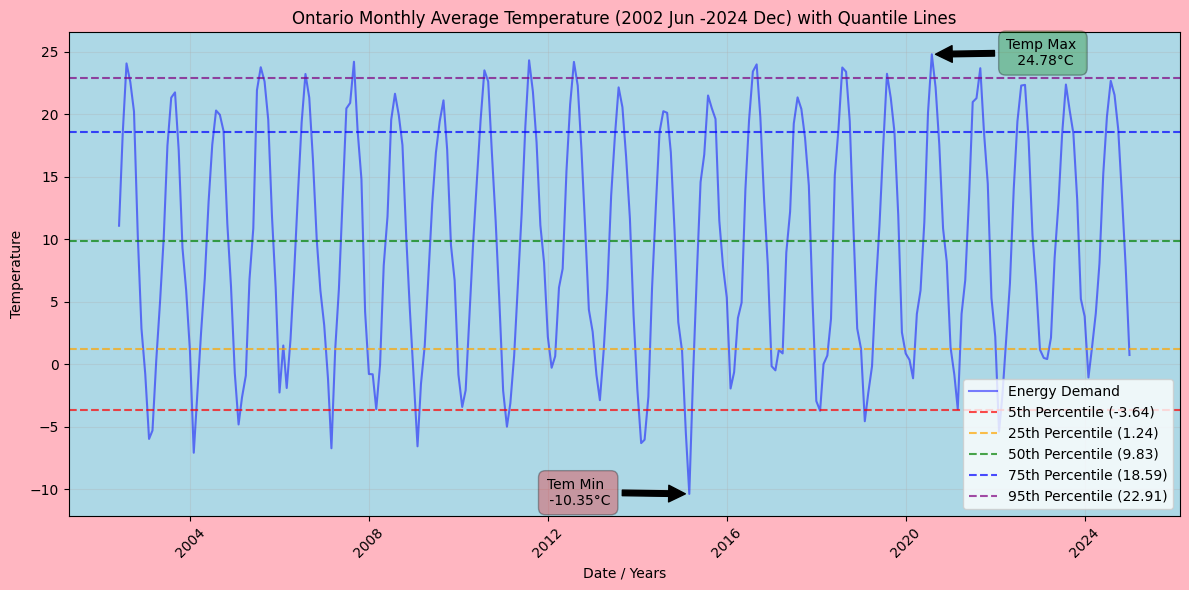

In [15]:
# quantiles
quantiles = weather_monthly.quantile([0.05, 0.25, 0.50, 0.75, 0.95])
print("Quantiles:")
print(quantiles)

# add color to quantiles to identiy each one
quantile_colors = {0.05: 'red', 0.25: 'orange', 0.50: 'green', 0.75: 'blue', 0.95: 'purple'}

# Time Series Plot with Quantile Lines
plt.figure(figsize=(12, 6),facecolor='lightpink')
plt.plot(weather_monthly.index, weather_monthly, label='Energy Demand', color='blue', alpha=0.5)

# Loop to indentify quantiles and set lines through plot
for q, value in quantiles.items():
    plt.axhline(y=value, color=quantile_colors[q], linestyle='--', alpha=0.7, label=f'{int(q*100)}th Percentile ({value:.2f})')

plt.annotate(f'Temp Max \n {round(weather_monthly.max(),2)}°C',xy=(weather_monthly.idxmax(), weather_monthly.max()), xytext=(80, -10), textcoords="offset points",
           ha='center', arrowprops=dict(facecolor='black', shrink=0.05),horizontalalignment='right', verticalalignment='bottom',
           bbox=dict(boxstyle="round,pad=0.5", fc="green", alpha=0.3))
plt.annotate(f'Tem Min \n {round(weather_monthly.min(),2)}°C',xy=(weather_monthly.idxmin(), weather_monthly.min()), xytext=(-80, -10), textcoords="offset points",
           ha='center', arrowprops=dict(facecolor='black', shrink=0.05),horizontalalignment='right', verticalalignment='bottom',
           bbox=dict(boxstyle="round,pad=0.5", fc="red", alpha=0.3))
asx = plt.gca()
asx.set_facecolor('lightblue')
plt.title('Ontario Monthly Average Temperature (2002 Jun -2024 Dec) with Quantile Lines')
plt.xlabel('Date / Years')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# Combine Energy + Temperature
combined_data = pd.DataFrame({
    'Energy': monthly_tot,
    'Temeprature': weather_monthly
})

combined_data.head(3)

,Energy,Temeprature
2002-05-31,11874901,11.082124
2002-06-30,12185238,18.454792
2002-07-31,14033343,24.051815


In [17]:
# Drop any NaN rows (if any) and adjust temperature decimal places
combined_data = combined_data.dropna()
combined_data['Temeprature'] = combined_data['Temeprature'].apply(lambda x: round(x,0))
combined_data.head(5)

,Energy,Temeprature
2002-05-31,11874901,11.0
2002-06-30,12185238,18.0
2002-07-31,14033343,24.0
2002-08-31,13748878,23.0
2002-09-30,12593138,20.0


In [23]:
# saving clean data
combined_data.to_csv('combined_data.csv')

In [ ]:
# Plot results
plt.plot(combined_data['Temeprature'], label='Actual')
plt.plot(combined_data['Energy'], label='Predicted')
plt.legend()
plt.show()

In [18]:
# Normalize the data for Energy and temperature be the same scale
scaler_combined = RobustScaler()
scaled_combine_data = scaler_combined.fit_transform(combined_data)

# Shape of Dat is 2 now, Create a sequence to lookback in the data (adapitable for 24 months)
lookback2 = 24
X, y = [], []
for i in range(lookback2, len(scaled_combine_data)):
    X.append(scaled_combine_data[i-lookback2:i])
    y.append(scaled_combine_data[i,0])
X, y = np.array(X), np.array(y)

# Split data into training, validation and testing sets (70-15-15)
training_set = int(len(X)*0.7)
valuation_set = int(len(X)*.15)
X_tr, X_v, X_te = X[:training_set],X[training_set:training_set+valuation_set], X[training_set+valuation_set:]
y_tr, y_v, y_te = y[:training_set],y[training_set:training_set+valuation_set], y[training_set+valuation_set:]

In [19]:
# Enhanced GRU model
model_gru_t = Sequential()
model_gru_t.add(GRU(units=64, input_shape=(lookback2, 2), return_sequences=True))
model_gru_t.add(Dropout(0.2))
model_gru_t.add(GRU(units=32, return_sequences=False))
model_gru_t.add(Dropout(0.2))
model_gru_t.add(Dense(units=16, activation='relu'))
model_gru_t.add(Dense(units=1)) # Final selection

model_gru_t.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_gru_t.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 24, 64)            13056     
                                                                 
 dropout_4 (Dropout)         (None, 24, 64)            0         
                                                                 
 gru_4 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 23,009
Trainable params: 23,009
Non-trai

In [20]:
# Training GRU
early_stop_t = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
his_gru = model_gru_t.fit(X_tr, y_tr, epochs=100, batch_size=16, validation_data=(X_v, y_v), callbacks=[early_stop_t])

# Prediction and Evaluation
y_pred_gru_scaled_t = model_gru_t.predict(X_te)
y_pred_gru_scaled_t_full = np.zeros((len(y_pred_gru_scaled_t),2)) # reconstruct 2D Inverse scaling
y_pred_gru_scaled_t_full[:,0] = y_pred_gru_scaled_t[:,0]  # prediction Energy
y_pred_gru_ener = scaler.inverse_transform(y_pred_gru_scaled_t_full)[:,0] # get energy
y_test_orig_t = scaler.inverse_transform(np.column_stack((y_te,X_te[:,-1,1])))[:,0]
mae_gru_t = mean_absolute_error(y_test_orig_t,y_pred_gru_ener)
print(f"GRU with Temperature Test MAE: {mae_gru_t:,.2f}")

Epoch 1/100
11/11 [==============================] - 3s 83ms/step - loss: 0.3579 - val_loss: 0.4641
Epoch 2/100
11/11 [==============================] - 0s 24ms/step - loss: 0.3029 - val_loss: 0.3874
Epoch 3/100
11/11 [==============================] - 0s 17ms/step - loss: 0.2858 - val_loss: 0.3411
Epoch 4/100
11/11 [==============================] - 0s 17ms/step - loss: 0.2602 - val_loss: 0.3235
Epoch 5/100
11/11 [==============================] - 0s 15ms/step - loss: 0.2504 - val_loss: 0.2917
Epoch 6/100
11/11 [==============================] - 0s 15ms/step - loss: 0.2131 - val_loss: 0.2631
Epoch 7/100
11/11 [==============================] - 0s 15ms/step - loss: 0.2099 - val_loss: 0.2293
Epoch 8/100
11/11 [==============================] - 0s 14ms/step - loss: 0.1802 - val_loss: 0.1873
Epoch 9/100
11/11 [==============================] - 0s 13ms/step - loss: 0.1694 - val_loss: 0.1611
Epoch 10/100
11/11 [==============================] - 0s 13ms/step - loss: 0.1356 - val_loss: 0.1313

In [24]:
# Save Model GRU (best performance)
model_gru_t.save('gru_model_temp.h5')

In [26]:
# Enhanced LSTM Model
model_lstm_t = Sequential()
model_lstm_t.add(LSTM(units=64, input_shape=(lookback2, 2), return_sequences=True))
model_lstm_t.add(Dropout(0.2))
model_lstm_t.add(LSTM(units=32, return_sequences=False))
model_lstm_t.add(Dropout(0.2))
model_lstm_t.add(Dense(units=16, activation='relu'))
model_lstm_t.add(Dense(units=1))

model_lstm_t.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_lstm_t.summary()

# Training
his_lstm_t = model_lstm.fit(X_tr, y_tr, epochs=100, batch_size=16, validation_data=(X_v, y_v), callbacks=[early_stop_t])

# Predict and evaluate
y_pred_lstm_scaled_t = model_lstm_t.predict(X_te)
y_pred_lstm_scaled_t_full = np.zeros((len(y_pred_lstm_scaled_t), 2))
y_pred_lstm_scaled_t_full[:, 0] = y_pred_lstm_scaled_t[:, 0]
y_pred_lstm_t = scaler.inverse_transform(y_pred_lstm_scaled_t_full)[:, 0]
mae_lstm_t = mean_absolute_error(y_test_orig_t, y_pred_lstm_t)
print(f"LSTM with Temperature Test MAE: {mae_lstm_t:,.2f}")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 24, 64)            17152     
                                                                 
 dropout_8 (Dropout)         (None, 24, 64)            0         
                                                                 
 lstm_6 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trai

In [27]:
# Save Model LSTM 
model_lstm_t.save('model_lstm_t_temp.h5')

In [22]:
min_test(mae_gru_t,mae_lstm_t)

GRU performed better results
GRU is 63.41% better than LSTM
